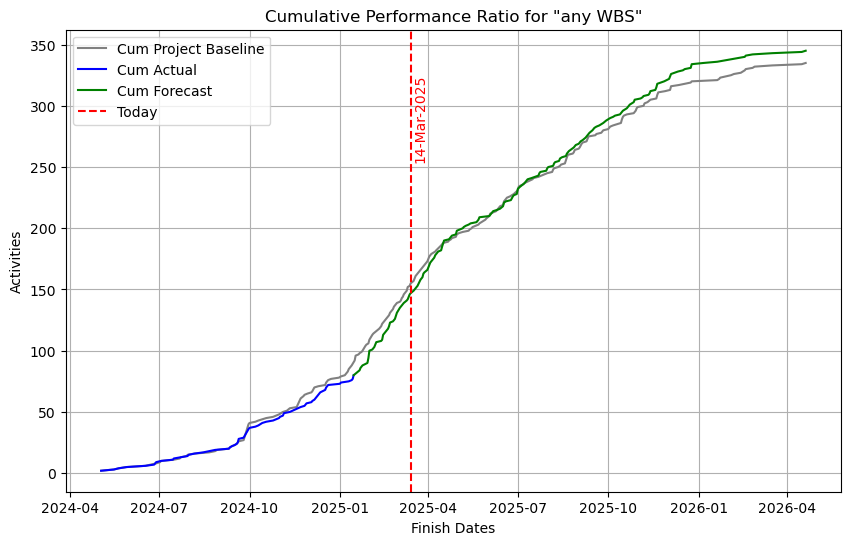

      Month  Actual/Forecast Completed  Planned Completed   CPR
0   2024-05                          5                  5  1.00
1   2024-06                          9                  8  1.12
2   2024-07                         15                 15  1.00
3   2024-08                         19                 19  1.00
4   2024-09                         36                 40  0.90
5   2024-10                         45                 48  0.94
6   2024-11                         57                 65  0.88
7   2024-12                         72                 78  0.92
8   2025-01                        100                109  0.92
9   2025-02                        131                139  0.94
10  2025-03                        166                173  0.96
11  2025-04                        198                195  1.02
12  2025-05                        209                208  1.00
13  2025-06                        228                228  1.00
14  2025-07                        249  

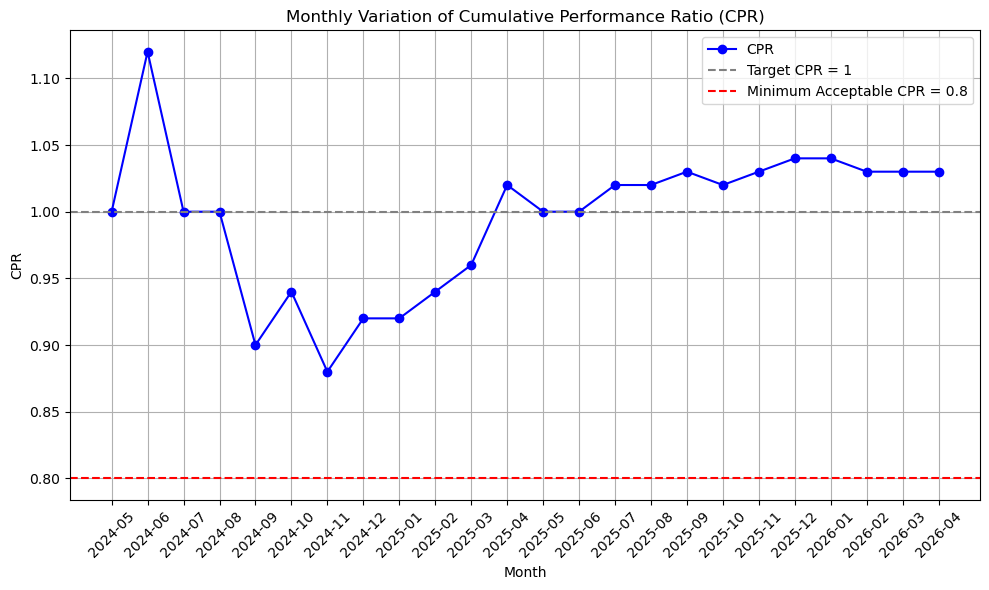

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel file
df = pd.read_excel('CPR (any WBS).xlsx')

# Convert dates to datetime format
df['BL Project Finish'] = pd.to_datetime(df['BL Project Finish'], errors='coerce')
df['Actual Finish'] = pd.to_datetime(df['Actual Finish'], errors='coerce')
df['Remaining Early Finish'] = pd.to_datetime(df['Remaining Early Finish'], errors='coerce')

# Create cumulative values for baseline, actual and forecast
data_sorted_bl = df.sort_values(by='BL Project Finish').dropna(subset=['BL Project Finish'])
data_sorted_actual = df.sort_values(by='Actual Finish').dropna(subset=['Actual Finish'])
data_sorted_forecast = df.sort_values(by='Remaining Early Finish').dropna(subset=['Remaining Early Finish'])

cumulative_bl = data_sorted_bl.groupby('BL Project Finish').size().cumsum()
cumulative_actual = data_sorted_actual.groupby('Actual Finish').size().cumsum()
cumulative_forecast = data_sorted_forecast.groupby('Remaining Early Finish').size().cumsum()

# Adjust the forecast to start where the current month ends
if not cumulative_actual.empty:
    last_actual_date = cumulative_actual.index[-1]
    last_actual_value = cumulative_actual.iloc[-1]
    
    # Ensure continuity: forecast starts one day after the last "Current Month" point
    next_forecast_date = last_actual_date + pd.Timedelta(days=1)
    cumulative_forecast = cumulative_forecast[cumulative_forecast.index >= next_forecast_date]
    cumulative_forecast = pd.concat(
        [pd.Series({last_actual_date: last_actual_value}),
         cumulative_forecast + last_actual_value]
    )

# Create the chart
plt.figure(figsize=(10, 6))
plt.plot(cumulative_bl.index, cumulative_bl.values, label='Cum Project Baseline', color='gray')
plt.plot(cumulative_actual.index, cumulative_actual.values, label='Cum Actual', color='blue')
plt.plot(cumulative_forecast.index, cumulative_forecast.values, label='Cum Forecast', color='green')

# Add vertical line for today
today = pd.Timestamp.now()
plt.axvline(today, color='red', linestyle='--', label='Today')

# Label the current date on the x-axis with a small offset
plt.text(today + pd.Timedelta(days=2), plt.ylim()[1] * 0.9, today.strftime('%d-%b-%Y'),
         color='red', rotation=90, va='top')

# Configure title and labels
plt.title('Cumulative Performance Ratio for "any WBS"')
plt.xlabel('Finish Dates')
plt.ylabel('Activities')
plt.legend()
plt.grid()

# Save chart as PNG with transparent background
plt.savefig('CPR (any WBS).png', format='png', transparent=True, dpi=300)

# Display the chart
plt.show()

# Combine "Actual Finish" and "Early Finish" data to create "Actual/Forecast Completed"
data_sorted_actual_forecast = pd.concat(
    [
        data_sorted_actual[['Actual Finish']],  # Use only relevant dates from Actual
        data_sorted_forecast[['Remaining Early Finish']].rename(columns={'Remaining Early Finish': 'Actual Finish'})  # Rename Early Finish to Actual Finish
    ]
).sort_values(by='Actual Finish').dropna(subset=['Actual Finish'])

# Group data by month and calculate corresponding cumulative values
cumulative_actual_forecast_by_month = data_sorted_actual_forecast.groupby(
    data_sorted_actual_forecast['Actual Finish'].dt.to_period('M')
).size().cumsum()

cumulative_bl_by_month = data_sorted_bl.groupby(
    data_sorted_bl['BL Project Finish'].dt.to_period('M')
).size().cumsum()

# Create a consolidated DataFrame for calculations
cpr_table = pd.DataFrame({
    'Actual/Forecast Completed': cumulative_actual_forecast_by_month,
    'Planned Completed': cumulative_bl_by_month
}).fillna(0)  # Fill NaN with 0 to avoid calculation problems

# Calculate the Cumulative Performance Ratio (CPR) with 2 decimals
cpr_table['CPR'] = (
    cpr_table['Actual/Forecast Completed'] / cpr_table['Planned Completed']
).replace([float('inf'), float('nan')], 0)
cpr_table['CPR'] = cpr_table['CPR'].round(2)  # Round CPR to 2 decimals

# Reset index to improve presentation
cpr_table = cpr_table.reset_index()
cpr_table.rename(columns={'index': 'Month'}, inplace=True)

# Display the table
print(cpr_table)

# Optional: save table as Excel file
cpr_table.to_excel('CPR_(any_WBS)_Table.xlsx', index=False)

import numpy as np

# Before plotting, fill zero values with interpolation
cpr_table['CPR'] = cpr_table['CPR'].replace(0, np.nan)  # Convert 0s to NaN
cpr_table['CPR'] = cpr_table['CPR'].interpolate(method='linear')  # Interpolate missing values

# Plot the monthly variation of CPR
plt.figure(figsize=(10, 6))
plt.plot(cpr_table['Month'].astype(str), cpr_table['CPR'], 
         marker='o', linestyle='-', color='blue', label='CPR')

# Configure title and labels
plt.title('Monthly Variation of Cumulative Performance Ratio (CPR)')
plt.xlabel('Month')
plt.ylabel('CPR')

# Reference line (CPR = 1, target)
plt.axhline(y=1, color='gray', linestyle='--', label='Target CPR = 1')

# Baseline (CPR = 0.8, minimum acceptable)
plt.axhline(y=0.8, color='red', linestyle='--', label='Minimum Acceptable CPR = 0.8')

# Rotate X-axis labels for better clarity
plt.xticks(rotation=45)

# Add legend and grid
plt.legend()
plt.grid()

# Adjust margins
plt.tight_layout()

# Save chart as PNG with transparent background
plt.savefig('Monthly Variaton of CPR (any WBS).png', 
            format='png', transparent=True, dpi=300)

# Display the chart
plt.show()